In [84]:
""" Load data from a local (client-side) file to postgres server with a transformation step on the file """

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

import psycopg2
import csv
import tempfile
from os import remove

def transform_load_file(sourcePath, connData, tableName, processRowFunc=None, hasHeader=False, sourceDelim=None):
    slashPos = sourcePath.rfind('/')+1
    fileExt = sourcePath[sourcePath.rfind('.')+1:].lower()
    tempWriteFile = tempfile.TemporaryFile(mode='w', newline='', delete=False)  #creates a 'temp' file in like appdata/local/temp.
    tempPath = tempWriteFile.name
    
    if sourceDelim is None:
        tempDelim = ',' if fileExt == 'csv' else ('\t' if fileExt == 'tsv' else '|')
    else:
        tempDelim = sourceDelim

    print('transforming file...')
    success = False

    #read original file, transform data to match aws table format, copy to local file (original unchanged, we upload the copy)
    with open(sourcePath,'r') as csvFile:
        csvReader = csv.reader(csvFile, delimiter=inDelim)
        if hasHeader: header = next(csvReader)  #get/skip header
        csvWriter = csv.writer(tempWriteFile, delimiter=tempDelim, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in csvReader:
            if processRowFunc: processRowFunc(row)
            csvWriter.writerow(row)
        
        success = True
    
    tempWriteFile.close()  #need to close the file do psycopg2 to allow open it. the delete=False on open prevents it from being deleted here

    if not success:
        print('failed to read/transform file - check local file name')
    else:
        print('copying to Postgres...')
        success = False

        #open connection to postgres
        with psycopg2.connect(**connData) as conn:
            cur = conn.cursor() 
                cur.copy_from(f, tableName, sep=tempDelim)

            conn.commit()  #need the commit here! not autocommitted like thru editor
            success = True

    if not success:
        print('something went wrong...')
    else:
        print('all good!')
    
    #clean up our temp file
    remove(tempPath)
    return success

In [83]:
#this stuff changes for file to uplaod
sourcePath = './data/cellData_2017-09-12_01-04-24.csv' #'E:/Box Sync/Vesicle Deformability/Results/Final Versions/2017_09_10 - SOPC old 1um GFP - 1 (t4-b2-a1)/cellData_2017-09-12_01-04-24.csv'
experimentNo = 1

#Host is given at Redshift > Clusters > [choose cluster] > [Endpoint] (minus the port#)
#database is created in query editor? redhsift gives you a db 'dev' and you connect to that and CREATE DATABASE somthingelse
connData = {
    'host':'127.0.0.1',
    'port':5432,
    'dbname':'research_data',
    'user':'postgres',
    'password':'admin'
}
tableName = 'prod.cell_data'

#operates in place to transform one raw data row to into format suitable for COPY FROM
def process_row_func_celldata(row):
    row[8] = str(10.0 if row[8] == '1.#J' else min(10.0, float(row[8])))  #fix aspect ratio really large or infinite
    row[9] = str(min(1.0, float(row[9])))  #circularity should be <= 1
    if len(row) > 14:
        del row[14] # remove blank column at end?
    del row[6]  #remove Spd column
    row.insert(0, experimentNo)  #prepend extra column for experiment #

transform_load_file(sourcePath, connData, tableName, processRowFunc=process_row_func_celldata, hasHeader=True)

transforming file...
copying to Postgres...
all good!


True

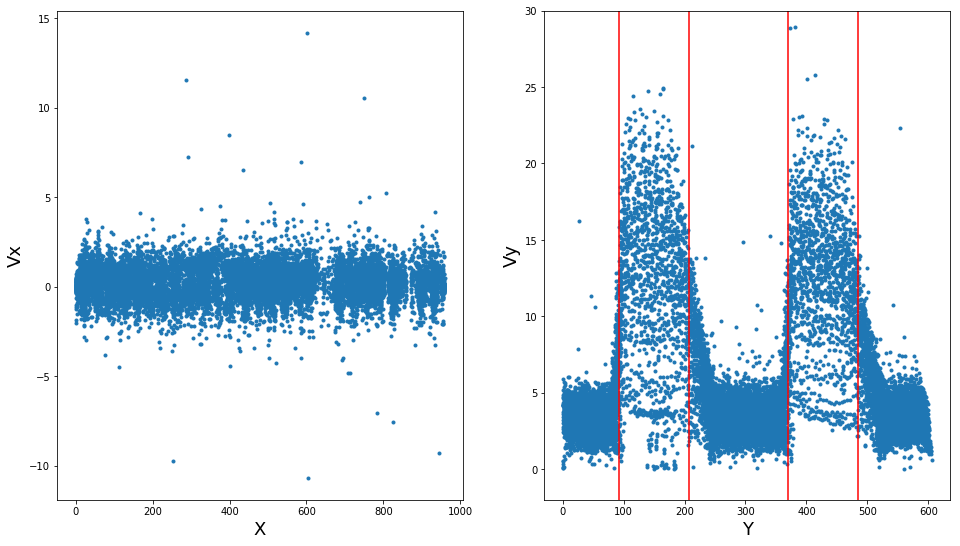

In [222]:
""" rollling into some unrelated but useful stats stuff below here """
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scistats
import numpy as np

%matplotlib inline

df = pd.read_csv(sourcePath, sep=',', header=[0], na_values=['1.#J'])
df.drop('Unnamed: 14', axis=1, inplace=True)
df.drop('Spd', axis=1, inplace=True)
df['Aspc'] = df['Aspc'].apply(lambda x: min(x,10.0))
df['Circ'] = df['Circ'].apply(lambda x: min(x,1.0))
df['Vy'] *= -1.0

df = df[ (df['Flags'].isnull()) & (df['Vy']>0) ]

# df.describe()
# df.corr()

# pd.plotting.scatter_matrix(df[['X','Vx','Y','Vy']])
# plt.show()

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_xlabel('X', fontsize=18)
ax1.set_ylabel('Vx', fontsize=18)

ax2.set_xlabel('Y', fontsize=18)
ax2.set_ylabel('Vy', fontsize=18)

ax1.scatter(df['X'].values, df['Vx'].values, marker='.')
ax2.scatter(df['Y'].values, df['Vy'].values, marker='.')

l1Bound = 93
r1Bound = 208
l2Bound = 370
r2Bound = 485
y1Bounds = [l1Bound, l1Bound]
y2Bounds = [r1Bound, r1Bound]
y3Bounds = [l2Bound, l2Bound]
y4Bounds = [r2Bound, r2Bound]
vBounds = [-2,30]
ax2.plot(y1Bounds, vBounds, 'r-')
ax2.plot(y2Bounds, vBounds, 'r-')
ax2.plot(y3Bounds, vBounds, 'r-')
ax2.plot(y4Bounds, vBounds, 'r-')

ax2.set_ylim(vBounds[0], vBounds[1])

plt.show()

In [220]:

topChannelDf = df[ (l1Bound<df['Y']) & (df['Y']<r1Bound) ]  # get rows where Y between l1 and r1 bound
validTopCells = topChannelDf['Cell ID'].unique()  # get distinct/unique list of cellIDs

vees = [topChannelDf[topChannelDf['Cell ID']==cellID]['Vy'].mean() for cellID in validTopCells]
topChannelVyAvg2 = pd.DataFrame({'Cell ID':validTopCells, 'mean':vees})  #these do the same thing
topChannelVyAvg = topChannelDf.groupby(['Cell ID'])['Vy'].mean()


botChannelDf = df[ (l2Bound<df['Y']) & (df['Y']<r2Bound) ]
botChannelVyAvg = botChannelDf.groupby(['Cell ID'])['Vy'].mean()

print('mean:', topChannelVyAvg.mean(), '    std:', topChannelVyAvg.std(), '    cnt:', topChannelVyAvg.count())
print()
print('mean:', botChannelVyAvg.mean(), '    std:', botChannelVyAvg.std(), '    cnt:', botChannelVyAvg.count())
scistats.ttest_ind(topChannelVyAvg, botChannelVyAvg)

mean: 12.139844627659768     std: 5.380611488950749     cnt: 213

mean: 13.214189015493973     std: 3.928418569648189     cnt: 194


Ttest_indResult(statistic=-2.281710546248778, pvalue=0.02302459011535764)

In [202]:

        
topChannelDf = df[ (l1Bound<df['Y']) & (df['Y']<r1Bound) ]  # get rows where Y between l1 and r1 bound
validTopCells = topChannelDf['Cell ID'].unique()  # get distinct/unique list of cellIDs

vees = [topChannelDf[topChannelDf['Cell ID']==cellID]['Vy'].mean() for cellID in validTopCells]
topChannelVyAvg2 = pd.DataFrame({'Cell ID':validTopCells, 'mean':vees})  #these do the same thing
topChannelVyAvg = topChannelDf.groupby(['Cell ID'])['Vy'].mean()


botChannelDf = df[ (l2Bound<df['Y']) & (df['Y']<r2Bound) ]
botChannelVyAvg = botChannelDf.groupby(['Cell ID'])['Vy'].mean()

print('mean:', topChannelVyAvg.mean(), '    std:', topChannelVyAvg.std(), '    cnt:', topChannelVyAvg.count())
print()
print('mean:', botChannelVyAvg.mean(), '    std:', botChannelVyAvg.std(), '    cnt:', botChannelVyAvg.count())
res = scistats.ttest_ind(topChannelVyAvg, botChannelVyAvg)

mean: 11.662717250931502     std: 5.190458103003787     cnt: 217

mean: 12.358441621611888     std: 3.952650491543803     cnt: 199


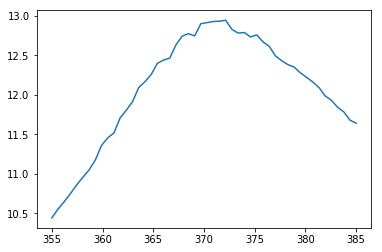

maxIdx: 28   maxAvg: 12.942164490343819   maxLBound: 372.14285714285717


In [217]:
def find_max_channel_avg(testDf, minRange, maxRange, diff, steps=20):
    #avgInBnd = np.zeros(int((maxRange-minRange)/step+1)
    avgInBnd = []
    for idx,lBnd in enumerate(np.linspace(minRange,maxRange,steps)):
        rBnd = lBnd + diff
        channelDf = testDf[ (lBnd<df['Y']) & (df['Y']<rBnd) ]
        avgVs = channelDf.groupby(['Cell ID'])['Vy'].mean()
        avgInBnd.append(avgVs.mean())
        #avgInBnd[lBnd-minRange] = avgVs.mean()
    avgInBnd = np.array(avgInBnd)
    return avgInBnd

fig = plt.figure()
ax = fig.add_subplot(111)
lowerMin = 355
lowerMax = 385
diff = 120
steps = 50
vs = find_max_channel_avg(df, lowerMin, lowerMax, diff, steps)
xs = np.linspace(lowerMin,lowerMax,steps)
ax.plot(xs, vs)
plt.show();
print('maxIdx:',np.argmax(vs), '  maxAvg:',vs[np.argmax(vs)], '  maxLBound:',xs[np.argmax(vs)])

In [150]:
myDf = topChannelDf.groupby(['Cell ID'])['Vy'].mean()

In [122]:
df[df['Flags'].isnull()]
pattern = r'[0-9]+.?y.*$'
pd.Series(['1', '2', '3y', '4_y', '5m']).str.contains(pattern)

0    False
1    False
2     True
3     True
4    False
dtype: bool

In [101]:
df.describe()

,Cell ID,Frame,X,Y,Vx,Vy,Area,Aspc,Circ,Ang,Per,Acc
count,46864.000000,46864.000000,46864.000000,46864.000000,46864.000000,46864.000000,46864.000000,42346.000000,46864.000000,46864.000000,46864.000000,46864.000000
mean,584.770527,1549.880271,445.909081,268.928165,0.113889,-3.629479,35.296160,1.844215,0.658728,59.611868,17.573244,39.079404
std,362.908007,852.748322,245.401998,175.037076,1.172849,4.343365,100.802821,1.557605,0.265236,51.385735,25.237644,112.543785
min,0.000000,50.000000,-104.660000,-299.080000,-25.870000,-35.900000,0.950000,1.000000,0.000000,0.000000,1.000000,-45.000000
25%,252.000000,775.000000,288.655000,150.390000,-0.230000,-4.580000,1.180000,1.000000,0.560000,0.000000,4.000000,-2.000000
50%,567.000000,1609.000000,403.180000,233.915000,0.000000,-3.200000,3.870000,1.350000,0.760000,74.800000,8.240000,7.430000
75%,897.000000,2316.000000,586.482500,373.512500,0.480000,-0.480000,17.130000,1.930000,0.810000,90.170000,18.490000,39.670000
max,1249.000000,3001.000000,984.830000,616.810000,21.140000,25.640000,940.560000,10.000000,1.000000,180.000000,207.100000,4604.820000


In [52]:
myStr = '64.2356'
def this_must_be_a_hack(myStr):
    try:
        float(myStr)
    except ValueError:
        return False
    return True

this_must_be_a_hack(myStr)

True